In [96]:
from nsepy import get_history
from tqdm.notebook import tqdm
import os
import pandas as pd
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from lib import util

listed_companies = util.get_merged_market_sector_data()
merged = util.get_close_values_for_topn(listed_companies, 50)
merged = util.merge_data_with_index(merged)
sectors = listed_companies.Sector
Y_all = merged.dropna()
index = 'NIFTY 50'
Y = Y_all[[col for col in Y_all.columns if col != index]]
Y_index = Y_all[[index]]
asset_classes = util.get_industry_for_assets(Y.columns.tolist(), listed_companies)

In [97]:
os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit

import vectorbt as vbt
from vectorbt.portfolio.nb import create_order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

vbt.settings.returns['year_freq'] = '252 days'

def prep_func_nb(simc, every_nth):
    # Define rebalancing days
    simc.active_mask[:, :] = False
    simc.active_mask[every_nth::every_nth, :] = True
    return ()


def segment_prep_func_nb(sc, find_weights_nb, rm, history_len, srb_sharpe):
    if history_len == -1:
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(close, rm)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    temp_float_arr = np.empty(sc.group_len, dtype=np.float_)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    sort_call_seq_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)


def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return create_order_nb(
        size=weights[col_i], 
        size_type=SizeType.TargetPercent, 
        price=oc.close[oc.i, oc.col]
    )

In [98]:
import riskfolio.Portfolio as pf
import riskfolio.RiskFunctions as rk

def opt_weights(close, rm):
    returns = Y.pct_change().dropna()
    port = pf.Portfolio(returns=returns)
    method_mu='hist'
    method_cov='hist'
    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = rm # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    weights = np.ravel(w.to_numpy())  
    shp = rk.Sharpe(w, port.mu, cov=port.cov, returns=returns, rm=rm, rf=0, alpha=0.05)

    return shp, weights

In [99]:
rms = ["MV", "MAD", "MSV", "CVaR", "EVaR", "WR", "CDaR", "MDD", "UCI"]

sharpe = {}
portfolio = {}

for i in tqdm(rms):
    sharpe[i] = np.full(Y.shape[0], np.nan)

    # Run simulation with a custom order function (Numba should be disabled)
    portfolio[i] = vbt.Portfolio.from_order_func(
        Y,
        order_func_nb,
        prep_func_nb=prep_func_nb,
        prep_args=(22*6,),
        segment_prep_func_nb=segment_prep_func_nb,
        segment_prep_args=(opt_weights, i, int(252*1.5), sharpe[i]),
        cash_sharing=True, 
        group_by=True,
        freq='D',
        incl_unrealized=True
    )

  0%|          | 0/9 [00:00<?, ?it/s]

<AxesSubplot:>

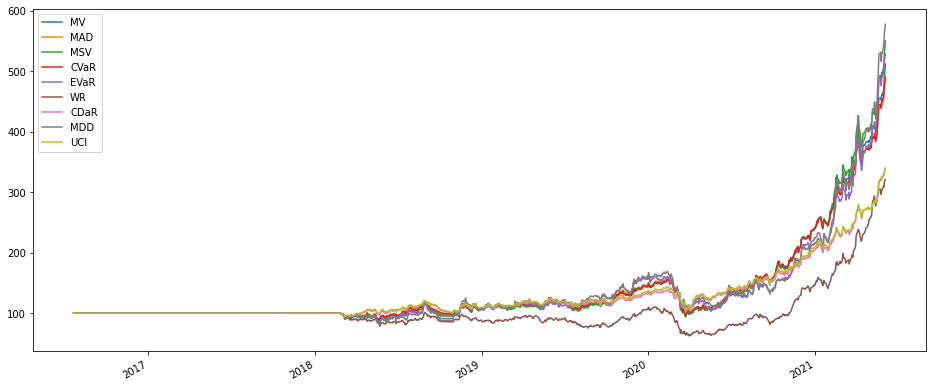

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,7))

values = pd.DataFrame([])
for i in rms:
    a = portfolio[i].value()
    values = pd.concat([values, a], axis=1)

values.columns = rms

values.plot(ax=ax)

In [104]:
stats = pd.DataFrame([])
for i in rms:
    a = portfolio[i].stats()
    stats = pd.concat([stats, a], axis=1)

stats.columns = rms

top_stats_cols = stats.loc['Num. Trades', :].astype(int).nsmallest(3).index.tolist()
display(stats[top_stats_cols])

,MDD,CDaR,WR
Start,2016-07-21 00:00:00,2016-07-21 00:00:00,2016-07-21 00:00:00
End,2021-06-04 00:00:00,2021-06-04 00:00:00,2021-06-04 00:00:00
Duration,1188 days 00:00:00,1188 days 00:00:00,1188 days 00:00:00
Init. Cash,100.0,100.0,100.0
Total Profit,477.274259,239.745164,221.107506
Total Return [%],477.274259,239.745164,221.107506
Benchmark Return [%],216.838377,216.838377,216.838377
Position Coverage [%],10.353535,7.575758,9.848485
Max. Drawdown [%],35.234979,26.898944,43.328955
Avg. Drawdown [%],5.558345,2.994268,5.880504


In [121]:
import plotly.graph_objects as go

def plot_allocation(rb_portfolio):
    # Plot weights development of the portfolio
    rb_asset_value = rb_portfolio.holding_value(group_by=False)
    rb_value = rb_portfolio.value()
    rb_idxs = np.flatnonzero((rb_portfolio.share_flow() != 0).any(axis=1))
    rb_dates = rb_portfolio.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=Y.columns,
        trace_kwargs=dict(
            stackgroup='one'
        ),
        width=1000,
        height=800
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()
    

# plot_allocation(portfolio['CDaR'])
portfolio['CDaR']?

SyntaxError: invalid syntax (<ipython-input-121-6fab775797f3>, line 33)